In [42]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
sns.set_theme(style='darkgrid')

In [43]:
pd.set_option("display.max_columns", None)

In [3]:
from data import get_data
from helpers import pred_to_perf

In [4]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8])
data.head()
data.to_csv('data/data.csv')

In [5]:
target_prices = data[['SMALL', 'LARGE']].fillna('ffill').shift(1).dropna()
bench_price = data['SPI'].fillna('ffill').shift(1).dropna()
features = data[data.columns[1:]].fillna('ffill').shift(1).dropna()

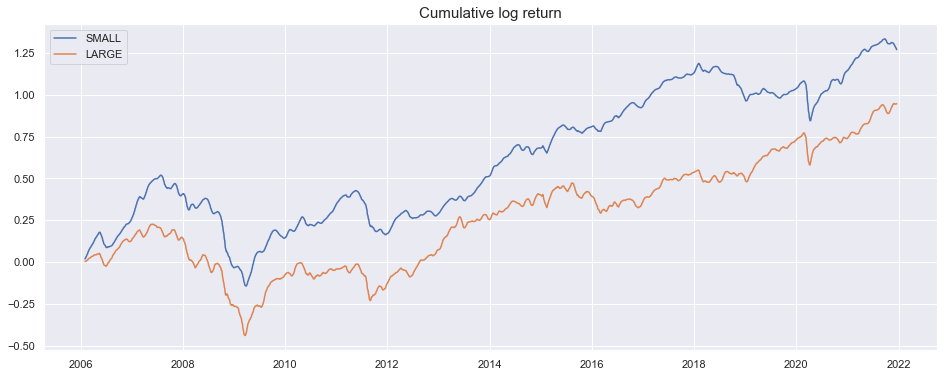

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = np.log((target_prices.pct_change() + 1).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.title('Cumulative log return', fontsize=15)
plt.show()

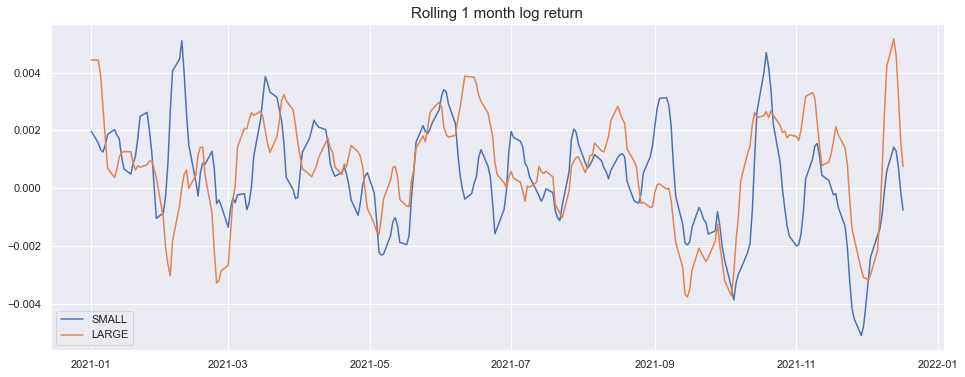

In [7]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0])/ len(x)).rolling(5).mean()
sns.lineplot(data=data_plot.loc['2021-01-01':], dashes=False)
plt.title('Rolling 1 month log return', fontsize=15)
plt.show()

In [8]:
data_stats = data[data.columns[:4]]
data_annual_ret = data_stats.pct_change().mean() * 252 * 100
data_annual_std = data_stats.pct_change().std() * np.sqrt(252) * 100
data_annual_sharpe = data_annual_ret.div(data_annual_std)
data_stats = pd.concat([data_annual_ret, data_annual_std, data_annual_sharpe], axis=1)
data_stats.columns = ['Annualized average return', 'Annualized Std', 'Sharpe Ratio']
data_stats.round(2)

,Annualized average return,Annualized Std,Sharpe Ratio
SPI,7.50,16.51,0.45
SMALL,8.18,10.19,0.80
MID,9.35,15.82,0.59
LARGE,7.34,17.18,0.43


In [9]:
weekly_returns = target_prices.resample('W-FRI').apply(lambda x: np.log(x[-1] / x[0]) / len(x))
best_pred = weekly_returns.rank(axis=1).replace({1: 0., 2: 1.}).shift(-1)

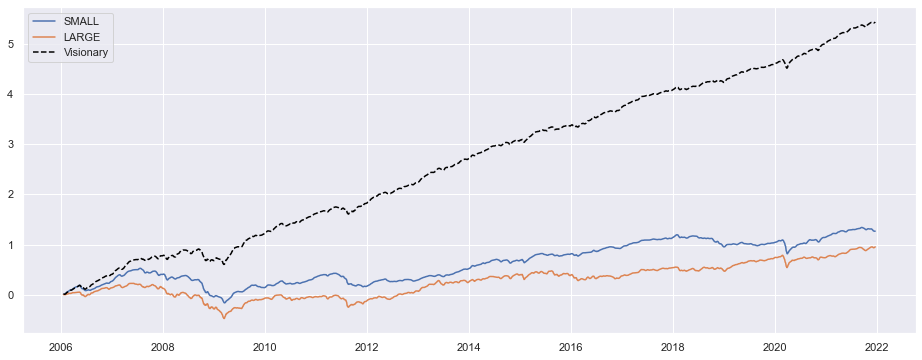

In [10]:
daily_returns = target_prices.pct_change()

fig, ax = plt.subplots(figsize=(16,6))
best_perf = np.log(pred_to_perf(best_pred, daily_returns=daily_returns).rolling(10).mean())
data_plot = np.log((target_prices.pct_change() + 1).reindex(best_perf.index).cumprod().rolling(10).mean())
sns.lineplot(data=data_plot, dashes=False)
sns.lineplot(data=best_perf, color='black', linestyle='--', label='Visionary')
plt.legend()
plt.show()

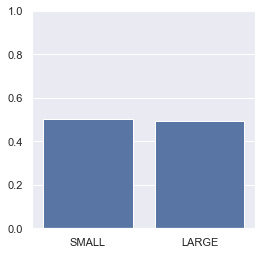

In [11]:
L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.ylim(0, 1)
plt.show()

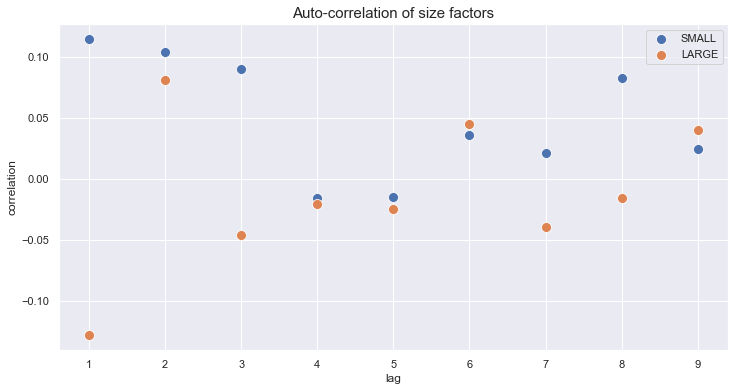

In [12]:
week_input_period = 10
auto_corr = {}
fig, ax = plt.subplots(figsize=(12, 6))
for size in weekly_returns.columns:
    auto_corr[size] = []
    for l in range(1, week_input_period):
        auto_corr[size].append(weekly_returns[size].corr(weekly_returns[size].shift(-l)))
    sns.scatterplot(x=range(1, week_input_period), y=auto_corr[size], label=size, s=100)
plt.xticks(range(1, week_input_period))
plt.title('Auto-correlation of size factors', fontsize=15)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

In [13]:
_, target_prices, features = get_data()

In [14]:
features.head()

,SMALL change,MID change,LARGE change,MATERIALS EU change,CONSUMER STAPLE EU change,INDUSTRIALS EU change,CONSUMER DIS. EU change,HEALTH CARE EU change,FINANCIALS EU change,VSMI change,VSTOXX change,VIX change,EURCHF change,USDCHF change,US 2YEAR change,US 5YEAR change,US 10YEAR change,OR change,SILVER change,BRENT change,SP500 change,RUSSELL 2000 change,SMALL ma20,MID ma20,LARGE ma20,MATERIALS EU ma20,CONSUMER STAPLE EU ma20,INDUSTRIALS EU ma20,CONSUMER DIS. EU ma20,HEALTH CARE EU ma20,FINANCIALS EU ma20,VSMI ma20,VSTOXX ma20,VIX ma20,EURCHF ma20,USDCHF ma20,US 2YEAR ma20,US 5YEAR ma20,US 10YEAR ma20,OR ma20,SILVER ma20,BRENT ma20,SP500 ma20,RUSSELL 2000 ma20,SMALL ma50,MID ma50,LARGE ma50,MATERIALS EU ma50,CONSUMER STAPLE EU ma50,INDUSTRIALS EU ma50,CONSUMER DIS. EU ma50,HEALTH CARE EU ma50,FINANCIALS EU ma50,VSMI ma50,VSTOXX ma50,VIX ma50,EURCHF ma50,USDCHF ma50,US 2YEAR ma50,US 5YEAR ma50,US 10YEAR ma50,OR ma50,SILVER ma50,BRENT ma50,SP500 ma50,RUSSELL 2000 ma50,SMALL vol21,MID vol21,LARGE vol21,MATERIALS EU vol21,CONSUMER STAPLE EU vol21,INDUSTRIALS EU vol21,CONSUMER DIS. EU vol21,HEALTH CARE EU vol21,FINANCIALS EU vol21,VSMI vol21,VSTOXX vol21,VIX vol21,EURCHF vol21,USDCHF vol21,US 2YEAR vol21,US 5YEAR vol21,US 10YEAR vol21,OR vol21,SILVER vol21,BRENT vol21,SP500 vol21,RUSSELL 2000 vol21,SMALL mom5,MID mom5,LARGE mom5,MATERIALS EU mom5,CONSUMER STAPLE EU mom5,INDUSTRIALS EU mom5,CONSUMER DIS. EU mom5,HEALTH CARE EU mom5,FINANCIALS EU mom5,VSMI mom5,VSTOXX mom5,VIX mom5,EURCHF mom5,USDCHF mom5,US 2YEAR mom5,US 5YEAR mom5,US 10YEAR mom5,OR mom5,SILVER mom5,BRENT mom5,SP500 mom5,RUSSELL 2000 mom5,SMALL mom10,MID mom10,LARGE mom10,MATERIALS EU mom10,CONSUMER STAPLE EU mom10,INDUSTRIALS EU mom10,CONSUMER DIS. EU mom10,HEALTH CARE EU mom10,FINANCIALS EU mom10,VSMI mom10,VSTOXX mom10,VIX mom10,EURCHF mom10,USDCHF mom10,US 2YEAR mom10,US 5YEAR mom10,US 10YEAR mom10,OR mom10,SILVER mom10,BRENT mom10,SP500 mom10,RUSSELL 2000 mom10,SMALL mom21,MID mom21,LARGE mom21,MATERIALS EU mom21,CONSUMER STAPLE EU mom21,INDUSTRIALS EU mom21,CONSUMER DIS. EU mom21,HEALTH CARE EU mom21,FINANCIALS EU mom21,VSMI mom21,VSTOXX mom21,VIX mom21,EURCHF mom21,USDCHF mom21,US 2YEAR mom21,US 5YEAR mom21,US 10YEAR mom21,OR mom21,SILVER mom21,BRENT mom21,SP500 mom21,RUSSELL 2000 mom21,SMALL RSI5,MID RSI5,LARGE RSI5,MATERIALS EU RSI5,CONSUMER STAPLE EU RSI5,INDUSTRIALS EU RSI5,CONSUMER DIS. EU RSI5,HEALTH CARE EU RSI5,FINANCIALS EU RSI5,VSMI RSI5,VSTOXX RSI5,VIX RSI5,EURCHF RSI5,USDCHF RSI5,US 2YEAR RSI5,US 5YEAR RSI5,US 10YEAR RSI5,OR RSI5,SILVER RSI5,BRENT RSI5,SP500 RSI5,RUSSELL 2000 RSI5,SMALL RSI10,MID RSI10,LARGE RSI10,MATERIALS EU RSI10,CONSUMER STAPLE EU RSI10,INDUSTRIALS EU RSI10,CONSUMER DIS. EU RSI10,HEALTH CARE EU RSI10,FINANCIALS EU RSI10,VSMI RSI10,VSTOXX RSI10,VIX RSI10,EURCHF RSI10,USDCHF RSI10,US 2YEAR RSI10,US 5YEAR RSI10,US 10YEAR RSI10,OR RSI10,SILVER RSI10,BRENT RSI10,SP500 RSI10,RUSSELL 2000 RSI10,SMALL MACD,MID MACD,LARGE MACD,MATERIALS EU MACD,CONSUMER STAPLE EU MACD,INDUSTRIALS EU MACD,CONSUMER DIS. EU MACD,HEALTH CARE EU MACD,FINANCIALS EU MACD,VSMI MACD,VSTOXX MACD,VIX MACD,EURCHF MACD,USDCHF MACD,US 2YEAR MACD,US 5YEAR MACD,US 10YEAR MACD,OR MACD,SILVER MACD,BRENT MACD,SP500 MACD,RUSSELL 2000 MACD
2006-03-15,2.54,6.21,-4.92,0.97,-0.06,-0.10,0.60,-0.37,0.16,-0.18,-0.1676,-0.63,-0.00576,-0.0140,-0.084,-0.093,-0.075,4.65,0.09,1.77,13.35,8.064,0.011674,0.011998,0.015198,-0.001407,0.012990,0.004484,0.014530,0.036561,0.008491,-0.035470,-0.067471,-0.106505,0.000985,-0.006256,-0.015281,0.003655,0.012875,-0.003877,0.044073,0.040516,0.009385,0.006729,0.047305,0.036892,0.028017,0.017777,0.033850,0.033095,0.028650,0.036165,0.040635,-0.086554,-0.084334,-0.126395,0.005465,0.005868,0.015816,0.036698,0.035722,-0.005764,0.073440,0.023312,0.013995,0.020243,119.562684,64.555704,52.695835,2.152573,1.193962,1.330053,0.605449,1.881325,1.539091,0.482085,0.688607,0.500962,0.003442,0.006138,0.031897,0.076004,0.083082,8.222368,0.319488,1.628315,6.705794,7.

In [24]:
daily_forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5).reindex(features.index)

df_features_corr = pd.DataFrame(index=target_prices.columns)
df_features_corr_pct = pd.DataFrame(index=target_prices.columns)

for col in features.columns:
    df_features_corr[col] = daily_forward_weekly_returns.corrwith(features[col])
display(df_features_corr.round(4) * 100)

<ipython-input-24-e2e0e476034c>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features_corr[col] = daily_forward_weekly_returns.corrwith(features[col])


,SMALL change,MID change,LARGE change,MATERIALS EU change,CONSUMER STAPLE EU change,INDUSTRIALS EU change,CONSUMER DIS. EU change,HEALTH CARE EU change,FINANCIALS EU change,VSMI change,VSTOXX change,VIX change,EURCHF change,USDCHF change,US 2YEAR change,US 5YEAR change,US 10YEAR change,OR change,SILVER change,BRENT change,SP500 change,RUSSELL 2000 change,SMALL ma20,MID ma20,LARGE ma20,MATERIALS EU ma20,CONSUMER STAPLE EU ma20,INDUSTRIALS EU ma20,CONSUMER DIS. EU ma20,HEALTH CARE EU ma20,FINANCIALS EU ma20,VSMI ma20,VSTOXX ma20,VIX ma20,EURCHF ma20,USDCHF ma20,US 2YEAR ma20,US 5YEAR ma20,US 10YEAR ma20,OR ma20,SILVER ma20,BRENT ma20,SP500 ma20,RUSSELL 2000 ma20,SMALL ma50,MID ma50,LARGE ma50,MATERIALS EU ma50,CONSUMER STAPLE EU ma50,INDUSTRIALS EU ma50,CONSUMER DIS. EU ma50,HEALTH CARE EU ma50,FINANCIALS EU ma50,VSMI ma50,VSTOXX ma50,VIX ma50,EURCHF ma50,USDCHF ma50,US 2YEAR ma50,US 5YEAR ma50,US 10YEAR ma50,OR ma50,SILVER ma50,BRENT ma50,SP500 ma50,RUSSELL 2000 ma50,SMALL vol21,MID vol21,LARGE vol21,MATERIALS EU vol21,CONSUMER STAPLE EU vol21,INDUSTRIALS EU vol21,CONSUMER DIS. EU vol21,HEALTH CARE EU vol21,FINANCIALS EU vol21,VSMI vol21,VSTOXX vol21,VIX vol21,EURCHF vol21,USDCHF vol21,US 2YEAR vol21,US 5YEAR vol21,US 10YEAR vol21,OR vol21,SILVER vol21,BRENT vol21,SP500 vol21,RUSSELL 2000 vol21,SMALL mom5,MID mom5,LARGE mom5,MATERIALS EU mom5,CONSUMER STAPLE EU mom5,INDUSTRIALS EU mom5,CONSUMER DIS. EU mom5,HEALTH CARE EU mom5,FINANCIALS EU mom5,VSMI mom5,VSTOXX mom5,VIX mom5,EURCHF mom5,USDCHF mom5,US 2YEAR mom5,US 5YEAR mom5,US 10YEAR mom5,OR mom5,SILVER mom5,BRENT mom5,SP500 mom5,RUSSELL 2000 mom5,SMALL mom10,MID mom10,LARGE mom10,MATERIALS EU mom10,CONSUMER STAPLE EU mom10,INDUSTRIALS EU mom10,CONSUMER DIS. EU mom10,HEALTH CARE EU mom10,FINANCIALS EU mom10,VSMI mom10,VSTOXX mom10,VIX mom10,EURCHF mom10,USDCHF mom10,US 2YEAR mom10,US 5YEAR mom10,US 10YEAR mom10,OR mom10,SILVER mom10,BRENT mom10,SP500 mom10,RUSSELL 2000 mom10,SMALL mom21,MID mom21,LARGE mom21,MATERIALS EU mom21,CONSUMER STAPLE EU mom21,INDUSTRIALS EU mom21,CONSUMER DIS. EU mom21,HEALTH CARE EU mom21,FINANCIALS EU mom21,VSMI mom21,VSTOXX mom21,VIX mom21,EURCHF mom21,USDCHF mom21,US 2YEAR mom21,US 5YEAR mom21,US 10YEAR mom21,OR mom21,SILVER mom21,BRENT mom21,SP500 mom21,RUSSELL 2000 mom21,SMALL RSI5,MID RSI5,LARGE RSI5,MATERIALS EU RSI5,CONSUMER STAPLE EU RSI5,INDUSTRIALS EU RSI5,CONSUMER DIS. EU RSI5,HEALTH CARE EU RSI5,FINANCIALS EU RSI5,VSMI RSI5,VSTOXX RSI5,VIX RSI5,EURCHF RSI5,USDCHF RSI5,US 2YEAR RSI5,US 5YEAR RSI5,US 10YEAR RSI5,OR RSI5,SILVER RSI5,BRENT RSI5,SP500 RSI5,RUSSELL 2000 RSI5,SMALL RSI10,MID RSI10,LARGE RSI10,MATERIALS EU RSI10,CONSUMER STAPLE EU RSI10,INDUSTRIALS EU RSI10,CONSUMER DIS. EU RSI10,HEALTH CARE EU RSI10,FINANCIALS EU RSI10,VSMI RSI10,VSTOXX RSI10,VIX RSI10,EURCHF RSI10,USDCHF RSI10,US 2YEAR RSI10,US 5YEAR RSI10,US 10YEAR RSI10,OR RSI10,SILVER RSI10,BRENT RSI10,SP500 RSI10,RUSSELL 2000 RSI10,SMALL MACD,MID MACD,LARGE MACD,MATERIALS EU MACD,CONSUMER STAPLE EU MACD,INDUSTRIALS EU MACD,CONSUMER DIS. EU MACD,HEALTH CARE EU MACD,FINANCIALS EU MACD,VSMI MACD,VSTOXX MACD,VIX MACD,EURCHF MACD,USDCHF MACD,US 2YEAR MACD,US 5YEAR MACD,US 10YEAR MACD,OR MACD,SILVER MACD,BRENT MACD,SP500 MACD,RUSSELL 2000 MACD
SMALL,10.70,10.43,6.41,8.15,4.55,8.42,8.29,4.00,5.82,-0.81,-2.11,-4.16,2.40,-0.41,6.18,6.34,5.13,1.99,1.05,5.81,5.30,6.94,14.16,15.66,12.56,15.87,11.79,14.96,15.77,4.47,13.53,-10.78,-11.42,-11.47,2.38,0.76,11.25,11.99,13.55,-8.92,-1.56,7.46,13.13,13.30,11.88,14.09,12.38,16.66,9.95,14.43,14.86,2.45,13.52,-11.83,-13.05,-13.72,4.21,-3.11,4.41,6.09,7.19,-7.98,2.32,8.40,12.80,12.63,2.47,0.87,0.38,-6.12,2.81,-1.07,0.70,4.09,-5.42,-2.47,-5.18,-5.97,-2.93,-3.88,-14.22,-9.48,-7.52,-0.05,1.17,-7.18,-2.21,-0.46,12.64,12.32,7.06,11.42,6.45,11.00,13.08,2.79,7.91,-4.80,-4.59,-3.69,3.19,1.18,11.71,9.26,9.55,-2.39,0.96,7.15,7.96,9.03,12.64,12.32,7.06,11.42,6.45,11.00,13.08,2.79,7.91,-4.80,-4.59,-3.69,3.19,1.18,11.71,9.26,9.55,-2.39,0.96,7.15,7.96,9.03,1

In [33]:
daily_forward_weekly_returns.iloc[:-5].isna()

,SMALL,LARGE
2006-03-15,False,False
2006-03-16,False,False
2006-03-17,False,False
2006-03-20,False,False
2006-03-21,False,False
...,...,...
2021-12-06,False,False
2021-12-07,False,False
2021-12-08,False,False
2021-12-09,False,False


In [34]:
df_features_stat = pd.DataFrame(index=target_prices.columns)
for feature in features:
    for target in daily_forward_weekly_returns:
        endog = daily_forward_weekly_returns[target].iloc[:-5]
        exog = features[feature].iloc[:-5]
        model = sm.OLS(endog, exog, missing='raise')
        results = model.fit()
        
        df_features_stat.at[target, feature] = results.pvalues.values
df_features_stat[df_features_stat < 0.05].round(4)

/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

,SMALL change,MID change,LARGE change,MATERIALS EU change,CONSUMER STAPLE EU change,INDUSTRIALS EU change,CONSUMER DIS. EU change,HEALTH CARE EU change,FINANCIALS EU change,VSMI change,VSTOXX change,VIX change,EURCHF change,USDCHF change,US 2YEAR change,US 5YEAR change,US 10YEAR change,OR change,SILVER change,BRENT change,SP500 change,RUSSELL 2000 change,SMALL ma20,MID ma20,LARGE ma20,MATERIALS EU ma20,CONSUMER STAPLE EU ma20,INDUSTRIALS EU ma20,CONSUMER DIS. EU ma20,HEALTH CARE EU ma20,FINANCIALS EU ma20,VSMI ma20,VSTOXX ma20,VIX ma20,EURCHF ma20,USDCHF ma20,US 2YEAR ma20,US 5YEAR ma20,US 10YEAR ma20,OR ma20,SILVER ma20,BRENT ma20,SP500 ma20,RUSSELL 2000 ma20,SMALL ma50,MID ma50,LARGE ma50,MATERIALS EU ma50,CONSUMER STAPLE EU ma50,INDUSTRIALS EU ma50,CONSUMER DIS. EU ma50,HEALTH CARE EU ma50,FINANCIALS EU ma50,VSMI ma50,VSTOXX ma50,VIX ma50,EURCHF ma50,USDCHF ma50,US 2YEAR ma50,US 5YEAR ma50,US 10YEAR ma50,OR ma50,SILVER ma50,BRENT ma50,SP500 ma50,RUSSELL 2000 ma50,SMALL vol21,MID vol21,LARGE vol21,MATERIALS EU vol21,CONSUMER STAPLE EU vol21,INDUSTRIALS EU vol21,CONSUMER DIS. EU vol21,HEALTH CARE EU vol21,FINANCIALS EU vol21,VSMI vol21,VSTOXX vol21,VIX vol21,EURCHF vol21,USDCHF vol21,US 2YEAR vol21,US 5YEAR vol21,US 10YEAR vol21,OR vol21,SILVER vol21,BRENT vol21,SP500 vol21,RUSSELL 2000 vol21,SMALL mom5,MID mom5,LARGE mom5,MATERIALS EU mom5,CONSUMER STAPLE EU mom5,INDUSTRIALS EU mom5,CONSUMER DIS. EU mom5,HEALTH CARE EU mom5,FINANCIALS EU mom5,VSMI mom5,VSTOXX mom5,VIX mom5,EURCHF mom5,USDCHF mom5,US 2YEAR mom5,US 5YEAR mom5,US 10YEAR mom5,OR mom5,SILVER mom5,BRENT mom5,SP500 mom5,RUSSELL 2000 mom5,SMALL mom10,MID mom10,LARGE mom10,MATERIALS EU mom10,CONSUMER STAPLE EU mom10,INDUSTRIALS EU mom10,CONSUMER DIS. EU mom10,HEALTH CARE EU mom10,FINANCIALS EU mom10,VSMI mom10,VSTOXX mom10,VIX mom10,EURCHF mom10,USDCHF mom10,US 2YEAR mom10,US 5YEAR mom10,US 10YEAR mom10,OR mom10,SILVER mom10,BRENT mom10,SP500 mom10,RUSSELL 2000 mom10,SMALL mom21,MID mom21,LARGE mom21,MATERIALS EU mom21,CONSUMER STAPLE EU mom21,INDUSTRIALS EU mom21,CONSUMER DIS. EU mom21,HEALTH CARE EU mom21,FINANCIALS EU mom21,VSMI mom21,VSTOXX mom21,VIX mom21,EURCHF mom21,USDCHF mom21,US 2YEAR mom21,US 5YEAR mom21,US 10YEAR mom21,OR mom21,SILVER mom21,BRENT mom21,SP500 mom21,RUSSELL 2000 mom21,SMALL RSI5,MID RSI5,LARGE RSI5,MATERIALS EU RSI5,CONSUMER STAPLE EU RSI5,INDUSTRIALS EU RSI5,CONSUMER DIS. EU RSI5,HEALTH CARE EU RSI5,FINANCIALS EU RSI5,VSMI RSI5,VSTOXX RSI5,VIX RSI5,EURCHF RSI5,USDCHF RSI5,US 2YEAR RSI5,US 5YEAR RSI5,US 10YEAR RSI5,OR RSI5,SILVER RSI5,BRENT RSI5,SP500 RSI5,RUSSELL 2000 RSI5,SMALL RSI10,MID RSI10,LARGE RSI10,MATERIALS EU RSI10,CONSUMER STAPLE EU RSI10,INDUSTRIALS EU RSI10,CONSUMER DIS. EU RSI10,HEALTH CARE EU RSI10,FINANCIALS EU RSI10,VSMI RSI10,VSTOXX RSI10,VIX RSI10,EURCHF RSI10,USDCHF RSI10,US 2YEAR RSI10,US 5YEAR RSI10,US 10YEAR RSI10,OR RSI10,SILVER RSI10,BRENT RSI10,SP500 RSI10,RUSSELL 2000 RSI10,SMALL MACD,MID MACD,LARGE MACD,MATERIALS EU MACD,CONSUMER STAPLE EU MACD,INDUSTRIALS EU MACD,CONSUMER DIS. EU MACD,HEALTH CARE EU MACD,FINANCIALS EU MACD,VSMI MACD,VSTOXX MACD,VIX MACD,EURCHF MACD,USDCHF MACD,US 2YEAR MACD,US 5YEAR MACD,US 10YEAR MACD,OR MACD,SILVER MACD,BRENT MACD,SP500 MACD,RUSSELL 2000 MACD
SMALL,0.0,0.0,0.0000,0.0,0.0025,0.0,0.0,0.0078,0.0003,NaN,NaN,0.0079,NaN,NaN,0.0001,0.0001,0.0013,NaN,NaN,0.0002,0.0004,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0015,0.0,0.0,0.0,0.0000,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0318,0.0000,0.0000,0.0000,0.0000,0.0482,0.0150,0.0231,0.0005,0.0000,0.0000,NaN,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0279,0.0,0.0004,0.0,0.0,0.0444,0.0278,NaN,NaN,NaN,0.0111,0.0195,NaN,NaN,0.0000,0.0000,NaN,0.0073,0.0004,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0497,0.0,0.0023,0.0036,0.0195,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0497,0.0,0.0023,0.0036,0.0195,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0

In [36]:
len(features.columns)

220

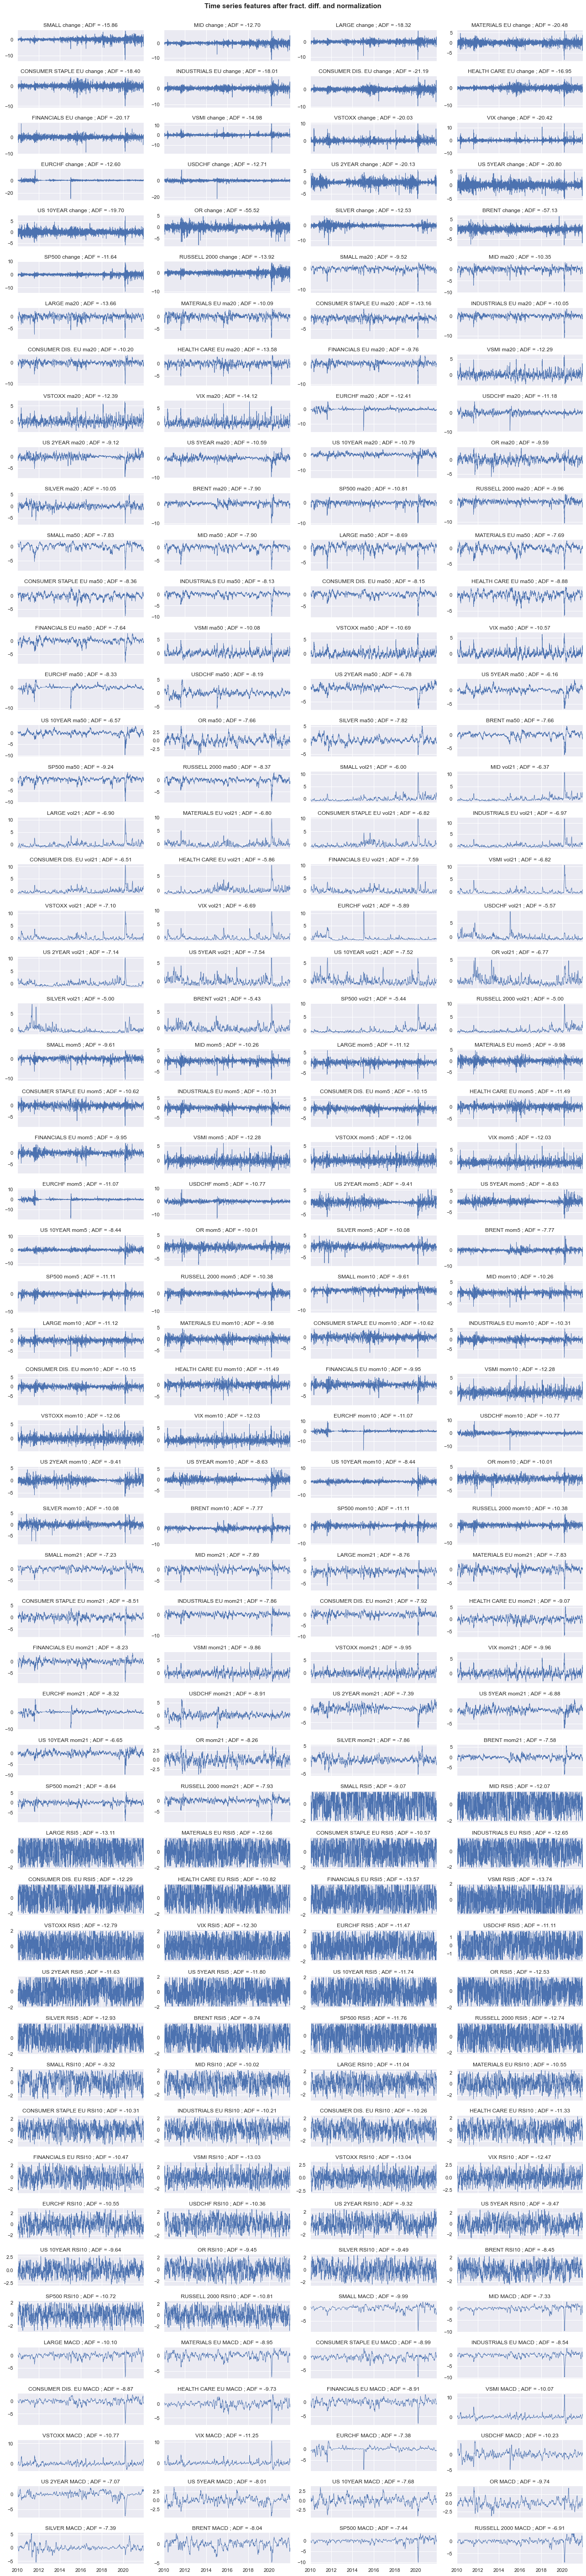

In [40]:
data_plot = features.loc['2010-01-01':]
data_plot = (data_plot - data_plot.mean()) / data_plot.std()


number_feature = len(data_plot.columns)
fig, axs = plt.subplots(55, 4, figsize=(18, 80), sharex=True)
axs = axs.ravel()

for i, col in enumerate(data_plot.columns):
    
    ads = adfuller(data_plot[col].values)[0]
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {ads:.2f}')

plt.suptitle('Time series features after fract. diff. and normalization', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.97)
plt.show()

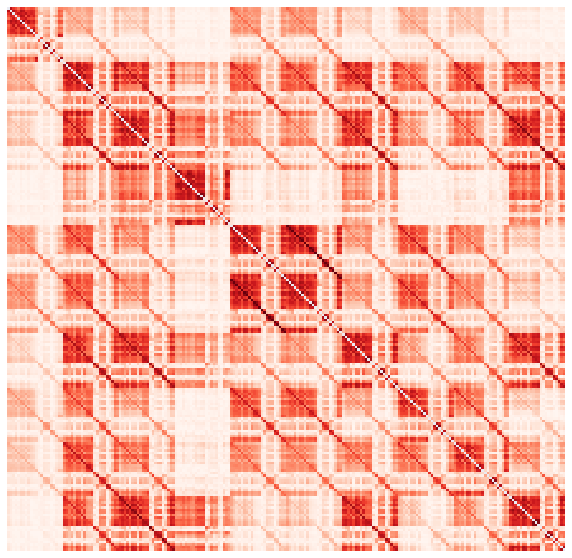

In [41]:
corr = data_plot.corr().abs().round(2)

fig, ax = plt.subplots(figsize=(10,10))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=False, cmap='Reds', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=8, labelbottom=False, labeltop=False, labelleft=False, length=0)
plt.show()